# FIT5201- ASSESSMENT 2 - Question I

- Student Name : Keerthana Muralitharan
- Student ID : 30159474

#### QUESTION 1 : [EM for Document Clustering, 40 Marks]

II. Implement the hard-EM (you derived above) and soft-EM (derived in Chapter 5 of Module 4). Please provide enough comments in your submitted code.

In [1]:
library(tm)
library(SnowballC)

Loading required package: NLP



In [2]:
eps=0.001
  
# reading the data
read.data <- function(file.name, sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
  # INPUTS:
  ## file.name: name of the input .txt file
  ## sample.size: if == 0  reads all docs, otherwise only reads a subset of the corpus
  ## seed: random seed for sampling (read above)
  ## pre.proc: if TRUE performs the preprocessing (recommended)
  ## spr.ratio: is used to reduce the sparcity of data by removing very infrequent words
  # OUTPUTS:
  ## docs: the unlabled corpus (each row is a document)
  ## word.doc.mat: the count matrix (each rows and columns corresponds to words and documents, respectively)
  ## label: the real cluster labels (will be used in visualization/validation and not for clustering)
  
  # Read the data
  text <- readLines(file.name)
  #print(text)
  # select a subset of data if sample.size > 0
  if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
  }
  ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
  docs <- strsplit(text, '\t')
  
  # store the labels for evaluation
  labels <-  unlist(lapply(docs, function(x) x[1]))
 
  # store the unlabeled texts    
  docs <- data.frame('doc_id'= seq(1,length(labels),1), 'text'= unlist(lapply(docs, function(x) x[2])), stringsAsFactors = FALSE)

  # create a corpus
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  }  
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}

In [3]:
## --- helper function ------------------------------------------------------------------ 
# Input:    logA1, logA2 ... logAn
# Output:   log(A1+A2+...+An)
#
# This function is needed to prevent numerical overflow/underflow when working with small numbers, 
# because we can easily get small numbers by multiplying p1 * p2 * ... * pn (where 0 <= pi <= 1 are probabilities).   
#
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

In [4]:
##--- Initialize model parameters randomly --------------------------------------------
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1)                    # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1)               # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}


### Hard EM for Document Clustering

- The E & M steps calculate the clustering based on Hard EM algorithm
- Each document is assigned to only one cluster based on **maximum value of probability** in E step
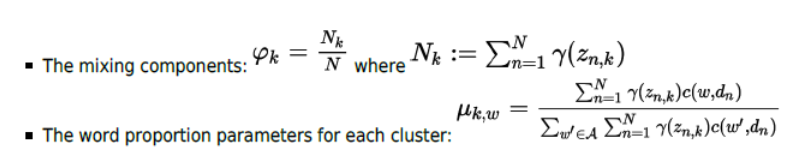

In [22]:
###--- E Step for Document Clustering  --------------------------------------------
# this function currently implements the E-step of the hard-EM
E.step.hard <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]

  # E step:    
    for (n in 1:N){
        for (k in 1:K){
          ## calculate the posterior based on the estimated mu and rho in the "log space"
          gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
        }
        # normalisation to sum to 1 in the log space
        logZ = logSum(gamma[n,])
        gamma[n,] = gamma[n,] - logZ
    }

    
    # converting back from the log space 
    gamma <- exp(gamma)
    
    # hard E step assignments:
    # for every point find the cluster with the maximum probability
    max.probability <- gamma == apply(gamma, 1, max) 
    gamma[max.probability] <- 1 # assign each point to the cluster with the highest probability
    gamma[!max.probability] <- 0 # remove points from clusters with lower probabilites

    
    return (gamma)
}

In [23]:
##--- M Step for Document Clustering  --------------------------------------------
M.step.hard <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters 
  epsilon=0.001

 # for every cluster
  for (k in 1:K){
      
    #calculate the rhovalue using the total  sum Nk
    Nk <- sum(gamma[,k])
    model$rho[k,1] = Nk/N
      
    #Calculate Mu value
    n <- c() #numerator
    d <- 0 #denominator

    #calculate the numerator and denominator
    for (w in 1:W){
        n <-  c(n,sum(counts[w,] * gamma[,k]))
      }

    for (w in 1:W){
        d <- d + sum(counts[w,] * gamma[,k])
      }

    #estimate the Mu value
    model$mu[k,] <- n/d
    #normalise the Mu value
    model$mu[k,] <- (model$mu[k,]+epsilon)/(sum(model$mu[k,])+W*epsilon) #normalising Mu
}
  
    # Returning the result
  return (model)
}

### Soft EM for Document Clustering
- The E & M steps calculate the clustering based on Soft EM algorithm
- The Probability of each document to a cluster is visualised at the end of each epoch

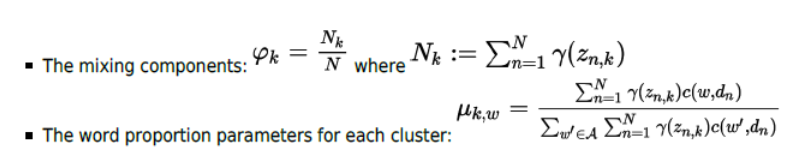

In [7]:
##--- E Step for Document Clustering  --------------------------------------------
# this function currently implements the E-step of the soft-EM
 
#
E.step.soft <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]

  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
  }
  
  # converting back from the log space 
  gamma <- exp(gamma)
  return (gamma)
}

In [8]:
##--- M Step for Document Clustering  --------------------------------------------
M.step.soft <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters

 
  # M step: Student needs to write this part for soft/hard EM
  #......
  #
  # hint: before you normalise a vector so that it sums to 1, first add a small number (eps) to all elements of the vector.
  # for example, suppose you have a vector [n1,n2,n3] and you want to normalise it to make it a probability distribution. 
  # you first need to add eps to elements [n1+eps,n2+eps,n3+eps], then divide the elements by (n1+n2+n3+ 3*eps) so that the vecotr sums to 1. 
  # this prevents NaN for vectors where all elements aer zero such as [0,0,0] because after adding eps you have [eps,eps,eps] which 
  # results in the uniform distribution after normalisation.  
      
epsilon=0.001
    
    #for every cluster
    for (k in 1:K){
        
    #Calculating the rho  based on the total sum Nk
    Nk <- sum(gamma[,k])
    model$rho[k,1] = sum(gamma[,k])/N
        
    #Calculate mu for every word
    n <- c() #numerator of mu
    d <- 0  #denomiator of mu
    
    for (w in 1:W){
        n <-  c(n,sum(counts[w,] * gamma[,k]))
      }
    for (w in 1:W){
        d <- d + sum(counts[w,] * gamma[,k])
      }

    #Estimating Mu value
    model$mu[k,] <- n/d
        
    #Normaising the Mu value
    model$mu[k,] <- (model$mu[k,]+epsilon)/(sum(model$mu[k,])+W*epsilon) #normalising mu
}
  
    # Returning the result
  return (model)
}

### Document Clustering function calls

In [9]:
##--- EM for Document Clustering --------------------------------------------
EM <- function(counts, K=4, max.epoch, seed=seed,type){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  print(train_obj(model,counts))

    if (type=='soft')
    {
        # Build the model
      for(epoch in 1:max.epoch){

        # E Step
        gamma <- E.step.soft(gamma, model, counts)
        # M Step
        model <- M.step.soft(gamma, model, counts)

        trn_ob = train_obj(model,counts)
        print(trn_ob)
        if (is.nan(trn_ob)){break;}
      }
      # Return Model
      return(list("model"=model,"gamma"=gamma))
    }
    
    if (type=='hard')
    {
        # Build the model
      for(epoch in 1:max.epoch){

        # E Step
        gamma <- E.step.hard(gamma, model, counts)
        # M Step
        model <- M.step.hard(gamma, model, counts)

        trn_ob = train_obj(model,counts)
          print(trn_ob)
        if (is.nan(trn_ob)){break;}
      }
      # Return Model
      return(list("model"=model,"gamma"=gamma))
    }
  
}


In [10]:
##--- the training objective function --------------------------------------------
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 
#   
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]

  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}


In [11]:
##--- Cluster Visualization -------------------------------------------------
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

##### Question III. 

Load Task2A.txt file and necessary libraries (if needed, perform text preprocessing similar to what we did in Activity 4.2), set the number of clusters K=4, and run both the soft-EM and hard-EM algorithms on the provided data.

In [12]:
#reading the data 
data <- read.data(file.name='Task2A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)
# word-document frequency matrix 
counts<-data$word.doc.mat
# word-document frequency matrix for hard EM
counts_hard <- data$word.doc.mat
# word-document frequency matrix for soft EM
counts_soft <- data$word.doc.mat

In [13]:
# calling the Hard EM algorithm on the data
res.hard <- EM(counts_hard, K=4, max.epoch=10, type='hard',seed=123)

[1] 2174573
[1] 2012179
[1] 2002462
[1] 1996405
[1] 1993006
[1] 1991112
[1] 1990400
[1] 1990070
[1] 1989795
[1] 1989276
[1] 1988182


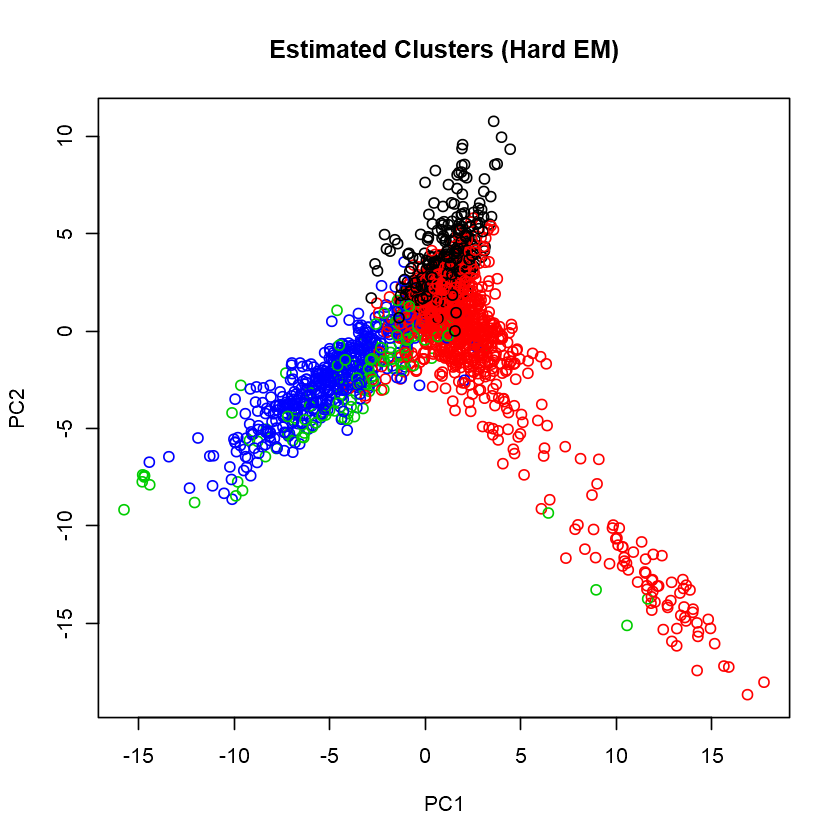

In [18]:
# visualization
## find the culster with the maximum probability (since we have soft assignment here)
label.hat <- apply(res.hard$gamma, 1, which.max) 
## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough

## visualize the stimated clusters
cluster.viz(t(counts), label.hat, 'Estimated Clusters (Hard EM)')

soft

In [19]:
# calling the Soft EM algorithm on the data
options(warn=-1)

res.soft <- EM(counts_soft, K=4, max.epoch=10, type='soft',seed=123)

[1] 2171895
[1] 2011117
[1] 1996455
[1] 1988764
[1] 1986707
[1] 1985614
[1] 1985028
[1] 1984881
[1] 1984853
[1] 1984816
[1] 1984813


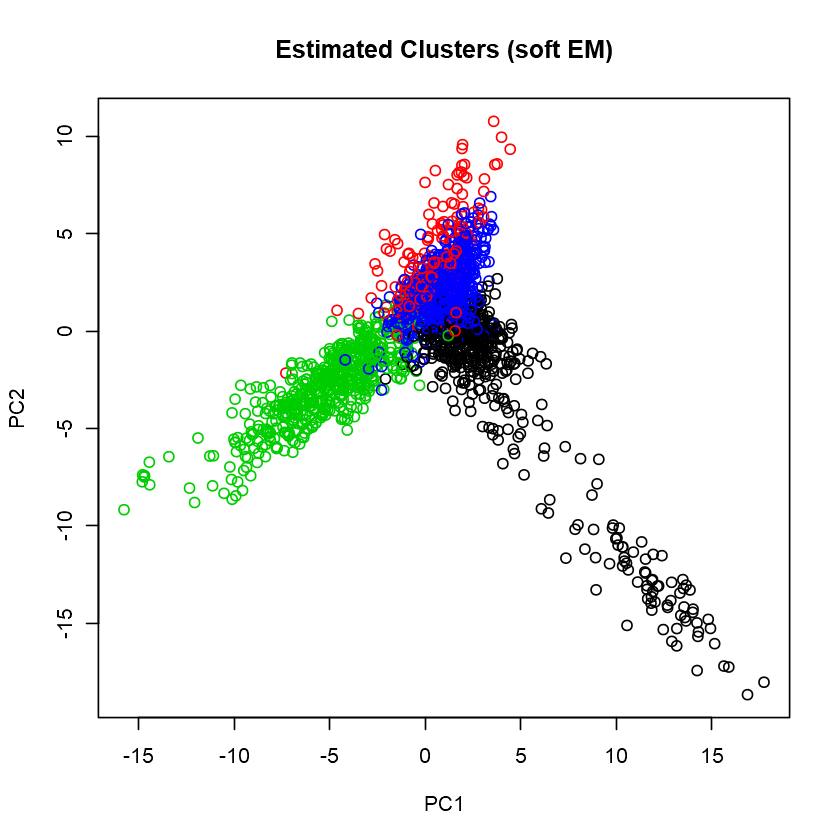

In [20]:
# visualization

## find the culster with the maximum probability (since we have soft assignment here)
label.hat <- apply(res.soft$gamma, 1, which.max) 
## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough

## visualize the stimated clusters
cluster.viz(t(counts), label.hat, 'Estimated Clusters (soft EM)')


### Original Clusters

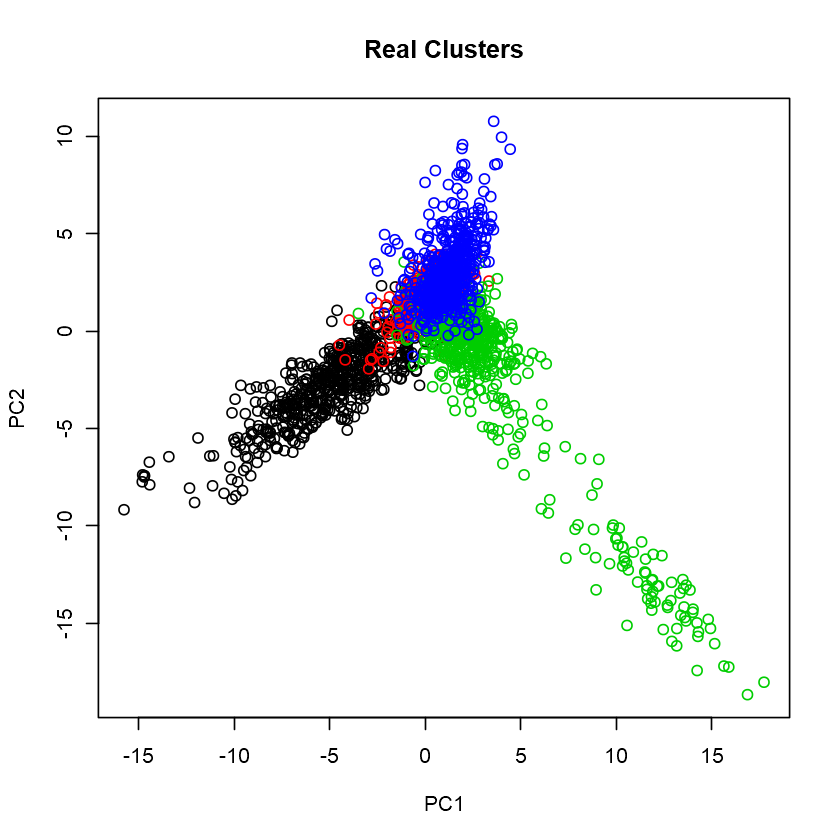

In [17]:
## visualize the real clusters
cluster.viz(t(counts), factor(data$label), 'Real Clusters')

**Inference**

As we could see the distribution is same across the soft EM document and hard EM document clustering. Also, we could see that the train objects for both the methods seems to be decreasing to the epoch count value. These 2 methods return the negative log likelihood (i.e) log P(counts|model).In soft EM we have all the 4 clusters are distinguishable as it uses probability for every datapoint . While the Hard- EM classifies into 2 possibilities with the cluster probability with value as 1 and 0, so there are many chances of datapoints in the clusters to get overlapped after PCA.